# Apprendimento con Pochi Dati Etichettati

## Apprendimento Automatico | LM in Data Science

####

da [documentazione](https://scikit-learn.org/stable/index.html) Scikit-learn

## Algoritmi Semi-supervisionati

### sezione `sklearn.semi_supervised` della libreria

Si usano pochi dati etichettati (e molti non etichettati) per task di _classificazione_

| classe | descrizione |
|:---:|:--:|
|[`SelfTrainingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.SelfTrainingClassifier.html) | classificatore che implementa il _self-training_ |
|[`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) | classificatore che implementa la _label propagation_ |
|[`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html) | modello per l'_apprendimento semi-supervisionato_ |


#### etichette mancanti in `y`

Identificatore per esempi non erichettati nel training set: `-1` 

**Nota**: per stringhe il `dtype` di `y` dovrebbe essere `object` per pter contenere sia stringhe sia interi

### Self Training

Con `SelfTrainingClassifier` si può usare un classificatore-base supervisionato per l'apprendimento *semi-supervisionato* usando anche dati non etichettati

- tale classificatore, indicato tramite il parametro `base_classifier`, deve implementare `predict_proba`
- ad ogni iterata, il `base_classifier` predice le etichette per gli esempi non etichettati e aggiunge un loro sottoinsieme al dataset etichettato
    - il parametro opzionale `max_iter` specifica il massimo numero di iterate da eseguire
        - impostato a `None`, l'algoritmo itera fino a quando tutti gli esempi sono etichettati oppure non siano stati selezionati nuovi esempi nell'iterata 
    - scelta del sottoinsieme determinata dal _criterio di selezione_
        - _soglia_ sulla probabilità di correttezza della predizione minima, come misura di confidenza (°)
        - alternativa: numero di esempi (param. `k_best`) con più alta probab. di predizione 
- alla fine sono disponibili come attributi le etichette usate nell'ultima iterazione in cui gli esempi sono tutti etichettati


(°): essenziale la [calibrazione](https://scikit-learn.org/stable/modules/calibration.html) del classificatore usato perché le probabilità di predizione possano essere usate come misure di confidenza.


#### Esempio 

test dell'effetto della variazione della _soglia_ su accuratezza, numero iterate (dalla [documentazione](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_self_training_varying_threshold.html))

- dataset `breast_cancer` modificato cancellando etichette: solo $50$ dei $569$ esempi restano etichettati

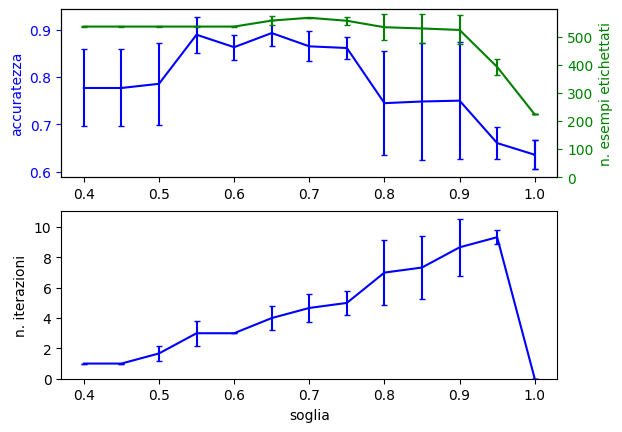

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle

n_splits = 3

X, y = load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1
total_samples = y.shape[0]

base_classifier = SVC(probability=True, gamma=0.001, 
                      random_state=42)

x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)
scores = np.empty((x_values.shape[0], n_splits))
amount_labeled = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))

for i, threshold in enumerate(x_values):
    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=threshold)

    # serve la CV manuale per non intepretare -1 come classe separata nel calcolo dell'accuratezza
    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)

        # numero di es. etichettati a fine-addestramento
        amount_labeled[i, fold] = (
            total_samples
            - np.unique(self_training_clf.labeled_iter_, return_counts=True)[1][0]
        )
        # ultima iterata in cui il classificatore abbia etichettato un esempio
        amount_iterations[i, fold] = np.max(self_training_clf.labeled_iter_)

        y_pred = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)


ax1 = plt.subplot(211)
ax1.errorbar(
    x_values, scores.mean(axis=1), yerr=scores.std(axis=1), capsize=2, color="b"
)
ax1.set_ylabel("accuratezza", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
ax2.errorbar(
    x_values,
    amount_labeled.mean(axis=1),
    yerr=amount_labeled.std(axis=1),
    capsize=2,
    color="g",
)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("n. esempi etichettati", color="g")
ax2.tick_params("y", colors="g")

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(
    x_values,
    amount_iterations.mean(axis=1),
    yerr=amount_iterations.std(axis=1),
    capsize=2,
    color="b",
)
ax3.set_ylim(bottom=0)
ax3.set_ylabel("n. iterazioni")
ax3.set_xlabel("soglia")

plt.show()

- (sopra) grafico  con il n. di esempi etichettati a disposizione (e accuratezza) a fine-training
- (sotto) grafico per l'_ultima iterata_ in cui si è etichettato un esempio (valori da 3-fold CV)
    - a soglie basse (in $[0.4, 0.5]$), il classificatore apprende da esempi etichettati<br> ma con anche con confidenza bassa, quindi da pseudo-etichette potenzialmente errate,<br> da cui la minore accuratezza dei classificatori corrispondenti
        - notare che gli esempi sono quasi tutti etichettati e basta $1$ iterata
    - per soglie alte (in $[0.9, 1[$) il classificatore non fa crescere il dataset ($0$ esempi auto-etichettati)<br> per cui l'accuratezza con soglia $0.9999$ è la stessa di un classificatore supervisionato normale
    - accurateza ottimale fra questi estremi con soglia attorno a $0.7$

#### Esercizio

- modificare l'esempio testando altri classificatori-base (binari)
    - introdurre anche la calibratura del classificatore

### Label Propagation

Varianti degli algo. semi-supervisionati di inferenza su grafo:
- usabili per problemi di classificazione
- metodi basati su kernel per proiettare i dati su spazi di diverse dimensionalità

Classi: `LabelPropagation` e `LabelSpreading`
- costruiscono un grado di similarità con tutti gli esempi del dataset
- differiscono nelle modifiche alla matrice di similarità e sull'effetto del <u>clamping</u> sulla distribuzioni delle etichette
    - il _clamping_ consente di cambiare il peso dei veri dati etichettati di base fino a un certo grado
- `LabelPropagation` adotta l'_hard clamping_ delle etichette in input, ossia un _fattore di clumping_ $\alpha=0$
    - può essere rilassato, ad esempio impostando $\alpha=0.2$ di conserva sempre l'80% della distribuzione originaria ma l'algoritmo può arrivare a cambiare la confidenza della distributione del 20%
    - adotta una matrice grezza
- `LabelSpreading` minimizza una loss regolarizzata, più robusta
    - si itera su una  versione modificata del grafo originario e si normalizzano i pesi sugli archi calcolando la matrice normalizzata del Laplaciano 
- kernel predefiniti:
    - RBF per matrici più dense / grafi connessi
    - kNN per matrici più sparse, maggiore efficienza del metodi

### Esempio

[Label propagation](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html) su dataset "digits"

- inizialmente modello addestrato con soli 10 es. etichettati
- si selezionano i 5 con etichetta più incerta
- ripete per 4 volte 
    - si apprende da 15 es. etichettati, 10 originari + 5 nuovi
- si ottiene un modello addestrato su 30 esempi etichettati 

Modifiche
- aumentando il numero oltre i 30 modificando `max_iterations`
    - utile per testare la velocità di convergenza di questa tencica di active learning 

Plot finale con le 5 cifre più incerte per ogni iterata di addestramento 
- possono contenere errori, ma sono utili all'addestramento del modello successivo con le loro vere etichette 


Iterata 1 ______________________________________________________________________
Label Spreading: 40 etichettati & 290 non etichettati (330 totali)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.78      0.69      0.73        26
           2       0.93      0.93      0.93        29
           3       1.00      0.89      0.94        27
           4       0.92      0.96      0.94        23
           5       0.96      0.70      0.81        33
           6       0.97      0.97      0.97        35
           7       0.94      0.91      0.92        33
           8       0.62      0.89      0.74        28
           9       0.73      0.79      0.76        34

    accuracy                           0.87       290
   macro avg       0.89      0.87      0.87       290
weighted avg       0.88      0.87      0.87       290

Matrice di confusione
[[22  0  0  0  0  0  0  0  0  0]
 [ 0 18  2  0  0  0  1  0  5  0]
 [ 0

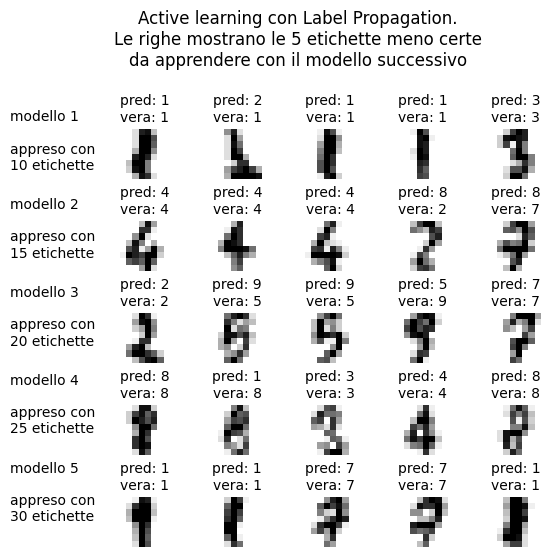

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.semi_supervised import LabelSpreading

digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

n_total_samples = len(y)
n_labeled_points = 40
max_iterations = 5

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]
f = plt.figure()

for i in range(max_iterations):
    if len(unlabeled_indices) == 0:
        print("fine dati non etichettati.")
        break
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1

    lp_model = LabelSpreading(gamma=0.25, max_iter=20)
    lp_model.fit(X, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]

    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

    print("\nIterata %i %s" % (i+1, 70 * "_"))
    print(
        "Label Spreading: %d etichettati & %d non etichettati (%d totali)"
        % (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples)
    )

    print(classification_report(true_labels, predicted_labels))

    print("Matrice di confusione")
    print(cm)

    # calcolo entropie delle distrib. delle etichette transdotte
    pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

    # seleziona fino a esempi su cui c'è più inceretezza
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.isin(uncertainty_index, unlabeled_indices)
    ][:5]

    # tiene traccia degli indici per i quali si acquisiscono etichette 
    delete_indices = np.array([], dtype=int)

    # in caso di più di 5 iterate: visualizza il gain solo sulle prime 5
    if i < 5:
        f.text(
            0.05,
            (1 - (i + 1) * 0.183),
            "modello %d\n\nappreso con\n%d etichette" % ((i + 1), i * 5 + 10),
            size=10,
        )
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        # in caso di più di 5 iterate: visualizza il gain solo sulle prime 5
        if i < 5:
            sub = f.add_subplot(5, 5, index + 1 + (5 * i))
            sub.imshow(image, cmap=plt.cm.gray_r, interpolation="none")
            sub.set_title(
                "pred: %i\nvera: %i"
                % (lp_model.transduction_[image_index], y[image_index]),
                size=10,
            )
            sub.axis("off")

        # labeling 5 points, remote from labeled set
        (delete_index,) = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

f.suptitle(
    (
        "Active learning con Label Propagation.\nLe righe mostrano le "
        "5 etichette meno certe\nda apprendere con il modello successivo"
    ),
    y=1.15,
)
plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.2, hspace=0.85)
plt.show()

#### Esempi

Confronto fra classificatori semi-supervisionati e SVM, dalla [](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_semi_supervised_versus_svm_iris.html)

- Label Spreading, Self-training e SVM su dataset Iris
    - il Label Spreading e il Self-training possono apprendere buoni modelli anche con pochi es. etichettati disponibili
    - è stato omesso il caso del 100% dei dati: Self-training identico all'SVC 

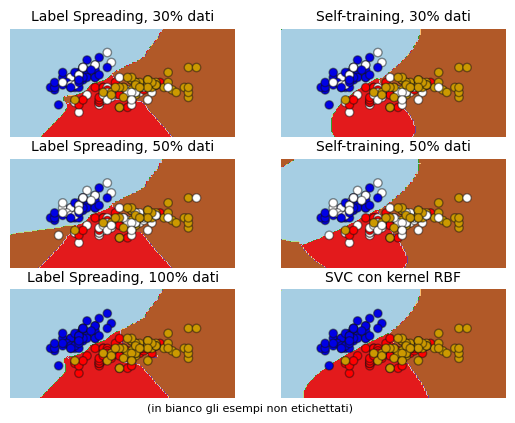

In [53]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier
from sklearn.svm import SVC

iris = datasets.load_iris()

X = iris.data[:, :2]
y = iris.target

# eliminzione parziale di etichette
rng = np.random.RandomState(0)
y_rand = rng.rand(y.shape[0])
y_30 = np.copy(y)
y_30[y_rand < 0.3] = -1  # per cancellare casualmente alcune etichette
y_50 = np.copy(y)
y_50[y_rand < 0.5] = -1
# si crea e addestra una SVM. 
# dati scalati dopo il plot dei vettori di supporto
ls30 = (LabelSpreading().fit(X, y_30), y_30, "Label Spreading, 30% dati")
ls50 = (LabelSpreading().fit(X, y_50), y_50, "Label Spreading, 50% dati")
ls100 = (LabelSpreading().fit(X, y), y, "Label Spreading, 100% dati")

# classificatore-base per il self-training identico al SVC
base_classifier = SVC(kernel="rbf", gamma=0.5, probability=True)
st30 = (
    SelfTrainingClassifier(base_classifier).fit(X, y_30),
    y_30,
    "Self-training, 30% dati",
)
st50 = (
    SelfTrainingClassifier(base_classifier).fit(X, y_50),
    y_50,
    "Self-training, 50% dati",
)

rbf_svc = (SVC(kernel="rbf", gamma=0.5).fit(X, y), y, "SVC con kernel RBF")



# passo nella griglia del plot
h = 0.04

# crea la griglia per il plot
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#color_map = {-1: (1, 1, 1), 0: (0, 0, 0.9), 1: (1, 0, 0), 2: (0.8, 0.6, 0)}

classifiers = (ls30, st30, ls50, st50, ls100, rbf_svc)
for i, (clf, y_train, title) in enumerate(classifiers):
    # Plot delle regioni di decisione 
    # colori diversi assegnati a ogni punto della griglia [x_min, x_max]x[y_min, y_max]
    plt.subplot(3, 2, i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # risultati nel plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("off")

    # Plot degli es. di training 
    colors = [color_map[y] for y in y_train]
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors="#11111177",)

    plt.title(title, fontsize=10)

plt.suptitle("(in bianco gli esempi non etichettati)", y=0.1, fontsize=8)
plt.show()

#### Altri Esempi

- [Label Propagation per una struttura complessa](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_structure.html)

## Altre Librerie

- active learning: [scikit-activeml](https://github.com/scikit-activeml/scikit-activeml)